In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline, Pipeline


In [2]:
df = pd.read_csv('loan_data.csv')
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [3]:
df.describe()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100
std,2.293890e+06,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398
min,1.000324e+06,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,8.999789e+06,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


no categorical variables. 
range of int variable is very different, need to scale them.

In [5]:
df.corr().style.background_gradient(cmap='coolwarm').format(precision=2)

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
customer_id,1.00,0.01,-0.01,0.00,-0.01,-0.01,0.01,0.01
credit_lines_outstanding,0.01,1.00,0.08,0.85,0.02,-0.09,-0.26,0.86
loan_amt_outstanding,-0.01,0.08,1.00,0.40,0.84,-0.16,-0.03,0.10
total_debt_outstanding,0.00,0.85,0.40,1.00,0.39,-0.17,-0.23,0.76
income,-0.01,0.02,0.84,0.39,1.00,0.00,-0.01,0.02
years_employed,-0.01,-0.09,-0.16,-0.17,0.00,1.00,0.26,-0.28
fico_score,0.01,-0.26,-0.03,-0.23,-0.01,0.26,1.00,-0.32
default,0.01,0.86,0.10,0.76,0.02,-0.28,-0.32,1.00


In [6]:
y = df['default']
X = df[df.columns[:-1]]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3)

In [7]:
X_train.corr().style.background_gradient(cmap='coolwarm').format(precision=2)

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score
customer_id,1.00,0.02,-0.02,0.01,-0.01,-0.00,0.02
credit_lines_outstanding,0.02,1.00,0.08,0.85,0.03,-0.08,-0.25
loan_amt_outstanding,-0.02,0.08,1.00,0.40,0.84,-0.16,-0.03
total_debt_outstanding,0.01,0.85,0.40,1.00,0.40,-0.17,-0.22
income,-0.01,0.03,0.84,0.40,1.00,0.00,-0.00
years_employed,-0.00,-0.08,-0.16,-0.17,0.00,1.00,0.26
fico_score,0.02,-0.25,-0.03,-0.22,-0.00,0.26,1.00


In [8]:
gbc_subpipeline = Pipeline(steps=[ ('GBC', GradientBoostingClassifier())])


param_grid = {
    'GBC__loss':     ['log_loss' , 'exponential'],
    'GBC__learning_rate':  [0.1,0.01]}


grid_search = GridSearchCV(gbc_subpipeline, param_grid, cv=5, n_jobs=-1, verbose=True, refit=True)
grid_search.fit(X_train, y_train)
best_gbc_reg = grid_search.best_estimator_

print('Best Hyperparameters:')
print(grid_search.best_params_)

# summarize best
print('Best MAE: %.3f'  % grid_search.best_score_)
print('Best Config: %s' % grid_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Hyperparameters:
{'GBC__learning_rate': 0.1, 'GBC__loss': 'exponential'}
Best MAE: 0.995
Best Config: {'GBC__learning_rate': 0.1, 'GBC__loss': 'exponential'}


In [9]:
gbc_pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                               ('gbc',    grid_search)])
gbc_pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Pipeline(steps=[('scaler', StandardScaler()),
                ('gbc',
                 GridSearchCV(cv=5,
                              estimator=Pipeline(steps=[('GBC',
                                                         GradientBoostingClassifier())]),
                              n_jobs=-1,
                              param_grid={'GBC__learning_rate': [0.1, 0.01],
                                          'GBC__loss': ['log_loss',
                                                        'exponential']},
                              verbose=True))])

In [10]:
y_pred = gbc_pipeline.predict(X_test)
gbc_pipeline.score(X_test,y_test)

0.9956666666666667

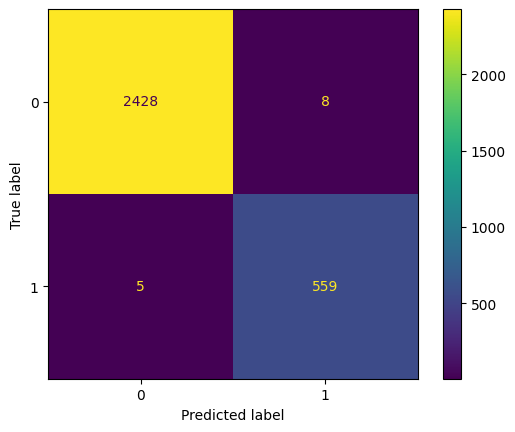

In [11]:
cm = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()